# DuffingNet: Training neural networks for characterizing a nonlinear oscillator

In this chapter, we employ a neural network to extract the underlying parameters of a physical system. The physical system is a nonlinear (Duffing) oscillator, and we simulate its response curve under driving.

The equation of motion we simulate is a simplified one:

$$
{\dot z} = -i (\omega_0 - \omega) z - {\gamma \over 2} z - i  {\varepsilon} |z|^2 z + i f
$$

Here $\omega_0$ is the resonance frequency (counted from some offset that itself is already much larger than the damping rate and everything else), $\omega$ is the driving frequency, $\gamma$ the damping rate, and $\varepsilon$ the strength of the nonlinearity, while $f$ is the strength of the external oscillating force. The response curves display the famous "shark fin" shape once the driving or the nonlinearity get stronger.

The response curve will be fed into the network, and it has to come up with the values of resonance frequency, nonlinearity, and damping. These values have been changed randomly during training.

(C) 2024 Florian Marquardt, Max Planck Institute for the Science of Light (MIT License)

## Imports and little helper routines

In [167]:
from matplotlib import pyplot as plt
%config InlineBackend.figure_format='retina'

import jax.numpy as jnp
from jax import grad, vmap, jit, value_and_grad
import jax
import jax.random

import optax

from functools import partial

import tqdm

### Little helper routine for initializing neural network

As before, in the previous chapter.

In [168]:
def NN_init_params(key, num_neurons_layers):
    """
    Given a jax random key and a list of the neuron numbers
    in the layers of a network (simple fully connected network,
    i.e. 'multi-layer perceptron'), return a dictionary
    with the weights initialized randomly and biases set to zero.
    
    Returns: params, with params['weights'] a list of matrices and
    params['biases'] a list of vectors.
    """
    params = {}
    params['weights'] = []
    params['biases'] = []
    
    for lower_layer, higher_layer in zip( num_neurons_layers[:-1], num_neurons_layers[1:] ):
        key,subkey = jax.random.split( key )
        params['weights'].append( jax.random.normal( subkey,
                                        [higher_layer,lower_layer] ) /  
                                 jnp.sqrt( lower_layer ) )
        
    for num_neurons in num_neurons_layers[1:]:
        params['biases'].append( jnp.zeros( num_neurons) )
    
    return params

### Runge Kutta solver (using jax, so it can easily be parallelized, run on GPU, etc)

A parallelizable Runge Kutta solver (hidden, since it is not the main topic here).

In [208]:
def runge_kutta_step_with_params(X,params,t,rhs,dt):
    """
    One step of the standard Runge-Kutta fourth order.
    This assumes rhs can be called like rhs(X,params,t)
    """
    k1=rhs(X,params,t)
    k2=rhs(X+0.5*dt*k1,params,t+0.5*dt)
    k3=rhs(X+0.5*dt*k2,params,t+0.5*dt)
    k4=rhs(X+dt*k3,params,t+dt)
    return( (dt/6.)*(k1+2*k2+2*k3+k4) )

# we need this partial statement to tell jax
# that the 'rhs' argument is not an array but something
# else!
@partial(jax.jit,static_argnames=['rhs'])
def runge_kutta_solve(X0,rhs,ts,params):
    """
    Solve the differential equation dX/dt=rhs(X,params,t), for all (equally spaced) times in ts,
    with initial value X(t=0)=X0.
    
    Here X0 can have ANY shape as an array, and rhs(X,params,t) must return the same shape.
    
    This is convenient in case you want to, say, do many trajectories in parallel,
    or reserve one index for the particle number, etc. You do not need to assume
    X to be a 1d array, as you would have to do for some other Runge-Kutta implementations.
    It is also nice to split the positions and velocities, e.g. X[0,:] for the positions
    of all particles, and X[1,:] for the velocities.
    
    Returns: Xs,ts
    
    where the shape of the solution Xs is the same as that of X, except we add another dimension
    at the end, of size 'nsteps'. 'ts' just is a 1d array denoting the time steps for
    the solution.
    
    Plotting the solution may work like this, if X was a 1d array:
    
    plt.plot(ts,Xs[5]) # Note that Xs[5] is the same as Xs[5,:]
    
    ...or like this, if e.g. X[1,:] were all the velocities of all particles:
    
    plt.plot(ts,Xs[1,3]) # plotting velocity of particle number 3: Xs[1,3] is the same as Xs[1,3,:]
    
    (code by Florian Marquardt 2020, 2024)
    """
    dt=ts[1]-ts[0]

    def loop_body(x,t):
        x+=runge_kutta_step_with_params(x,params,t,rhs,dt)
        return x,x
    
    _,Xs=jax.lax.scan(loop_body,X0,xs=ts)
    return Xs,ts

# batched parameters:
parallel_param_runge_kutta_solve = vmap(runge_kutta_solve,in_axes=[None,None,None,0],
                                                   out_axes=0)

# batched initial conditions:
parallel_runge_kutta_solve = vmap(runge_kutta_solve,in_axes=[0,None,None,None],
                                                   out_axes=0)

## Apply neural networks to predict the physical parameters from response curves in the Duffing model of a nonlinear driven oscillator

### Duffing equation and the Duffing model solver

Defining right-hand-side and using runge_kutta_solve to solve the equations of motion:

In [209]:
def duffing_rhs(z,rhs_params,t):
    # params = [omega_start, domega_dt , gamma, epsilon, force, omega0]
    return ( (-1j*(rhs_params[5]-(rhs_params[0]+rhs_params[1]*t)) - 0.5*rhs_params[2])*z 
            -1j*rhs_params[3]*jnp.abs(z)**2 * z + 1j*rhs_params[4] )

def solve_duffing(z0, omega0, gamma, epsilon, force, omega_start, omega_stop, t_end, nsteps):
    ts=jnp.linspace(0.,t_end, nsteps)
    domega_dt = (omega_stop - omega_start)/t_end 
    rhs_params=jnp.array([omega_start, domega_dt , gamma, epsilon, force, omega0])
    omegas=omega_start + domega_dt * ts
    return *runge_kutta_solve(z0, duffing_rhs, ts, rhs_params),omegas

# batch-processing version, where omega0,gamma,epsilon can vary across
# the samples of the batch:
solve_duffing_parameter_batch = vmap(solve_duffing,
                                    in_axes=[None,0,0,0,None,None,None,None,None])

# batch-processing version, which can be used to compute a force sweep:
solve_duffing_force_batch = vmap(solve_duffing,
                                 in_axes=[None,None,None,None,0,None,None,None,None],
                                out_axes=0)


First tests of Duffing solver:

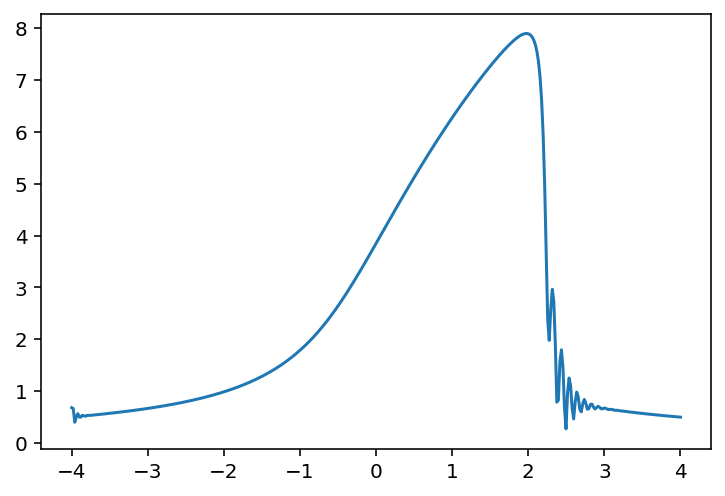

In [206]:
zs,ts,omegas = solve_duffing( 0.0+0.01j, omega0=0.0, omega_start=-4.0, 
                    omega_stop=+4.0, gamma=.5, 
                      epsilon=0.03, force=2.0, 
                      t_end=200.0, nsteps=400 )

plt.plot(omegas,jnp.abs(zs))
plt.show()

Now the same, but for a sweep of forces. We use the ```solve_duffing_force_batch``` that was defined above using the neat jax ```vmap``` trick. Note that to use this properly, we cannot name the arguments any more (unlike above):

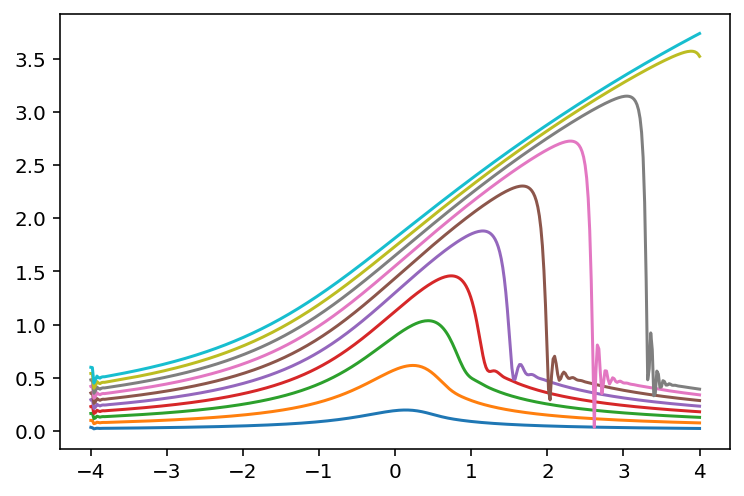

In [207]:
zs,ts,omegas = solve_duffing_force_batch( 0.0+0.01j, 0.0,
                                     1.0, 
                      0.3, jnp.linspace(0.1,2.0,10), 
                     -4.0, +4.0,
                      200.0, 400 )

for j in range(10):
    plt.plot(omegas[j],jnp.abs(zs[j]))
plt.show()

### Train a neural network to predict the parameters by looking at one noisy response curve

Define a little helper routine that produces a training batch of response curves for randomly chosen resonance frequency (omega0), nonlinearity (epsilon), and damping (gamma).

In [74]:
def random_parameter_vectors( key, batchsize , ranges ):
    """
    Produce several vectors of length batchsize, with values randomly
    uniformly distributed within the respective values range [min_val,max_val].
    ranges is a list of such value ranges.
    
    Returns: list of random vectors.
    """
    subkeys = jax.random.split( key, len(ranges) )
    return [ jax.random.uniform( subkey, [ batchsize ], 
                                      minval = value_range[0], maxval = value_range[1] )
            for subkey, value_range in zip(subkeys, ranges) ]

def duffing_produce_training_batch( key, batchsize, ranges , num_frequency_bins,
                                  force=1.0, omega_start=-4.0, omega_end=+4.0,
                                  t_end=200.0, n_steps=400):
    """
    Produce a Duffing model training batch.
    Random values for omega0, gamma, and epsilon are generated uniformly
    in the ranges given in the list 'ranges' (a list of [min_val,max_val] entries).
    
    Returns:
    x, y_target
    
    where
    
    x is of shape [batchsize, num_frequency_bins] and represents the response curves
    y_target is of shape [batchsize, 3] and gives (omega0,gamma,epsilon) for each sample
    """
    omega0s, gammas, epsilons = random_parameter_vectors( key, batchsize, ranges )
    zs,_,_ = solve_duffing_parameter_batch( 0.0+0.0j, omega0s, gammas, epsilons, 
                                 force, omega_start, omega_end, t_end, n_steps )
    x = jax.image.resize( jnp.abs(zs), [ batchsize, num_frequency_bins ] , "linear")
    return x, jnp.stack([omega0s,gammas,epsilons],1)
     
    

Illustrate the variety of response curves one gets in a batch.

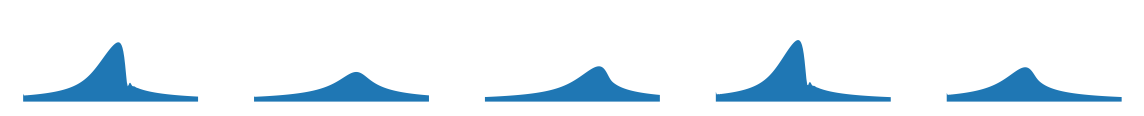

In [205]:
key = jax.random.key( 44 )
num_panels = 5
npixels = 200

x, y_target = duffing_produce_training_batch( key, num_panels, 
                                             [[-1.,1.],[0.5,1.5],[0.0,0.15]], npixels)

omegas = jnp.linspace(-4.,4.,npixels)
fig,ax=plt.subplots(ncols = num_panels, sharey = True, figsize=(10,2))
for idx in range(num_panels):
    ax[idx].fill_between(omegas,0*omegas,x[idx,:])
    ax[idx].set_ylim(0.,4.)
    ax[idx].set_aspect(1.0)
    ax[idx].axis('off')
    omega0,gamma,epsilon=y_target[idx,:]
plt.show()

Define a standard multilayer perceptron (fully connected network), with tanh activations except for the last layer (which has a linear activation). Also define the simple mean-square-error loss function for a batch of samples (using the vmap method of jax). This is all generic and exactly the same as in the previous chapter.

In [75]:
def NN_MLP_with_tanh(x, params):
    """
    Standard MLP with params['weights'] and params['biases'],
    applied to input vector x. Activation tanh applied to all
    layers except last.
    """
    num_layers=len(params['weights'])
    for layer_idx, (weights, biases) in enumerate(zip(params['weights'],params['biases'])):
        x = jnp.matmul(weights,x) + biases
        if layer_idx < num_layers-1:
            x = jnp.tanh( x )
    return x

# produce a batched version (where x has a batch dimension 0)
NN_MLP_with_tanh_batch = vmap(NN_MLP_with_tanh, in_axes=[0,None], out_axes=0)

# batch-averaged mean-square-error deviation between x and y_target:
def mse_loss_batch(x, y_target, params):
    return jnp.sum( ( NN_MLP_with_tanh_batch(x,params) - y_target )**2 ) / jnp.shape(x)[0]

# take gradient with respect to params (argument number '2' out of 0,1,2)
# also return value of loss:
mse_loss_batch_val_grad = value_and_grad(mse_loss_batch, argnums=2)

Initialize the neural network parameters and prepare the optax optimizer. This defines some parameters specific to our application.

In [172]:
num_frequency_bins = 50 # will be input dimension
num_physics_parameters = 3 # output dimension
learning_rate = 1e-3

key = jax.random.key( 42 )

subkey, key = jax.random.split(key)
params = NN_init_params( subkey, [num_frequency_bins, 100, num_physics_parameters] )

optimizer = optax.adam( learning_rate )
opt_state = optimizer.init( params )

Prepare some parameters for the training loop.

In [173]:
# training parameters
num_training_batches = 100
batchsize = 32
value_ranges = [[-1.,1.],[0.5,1.5],[0.0,0.15]] # omega0, gamma, epsilon
losses=[]


Now run the training loop! Produce a training batch, evaluate the network on this batch and get the gradients of the loss function with respect to the neural network parameters, update the parameters

Note: If you want a nice progress bar during training, insert ```from tqdm import tqdm``` at the top of the cell and then use ```tqdm(range(...))``` instead of ```range```.

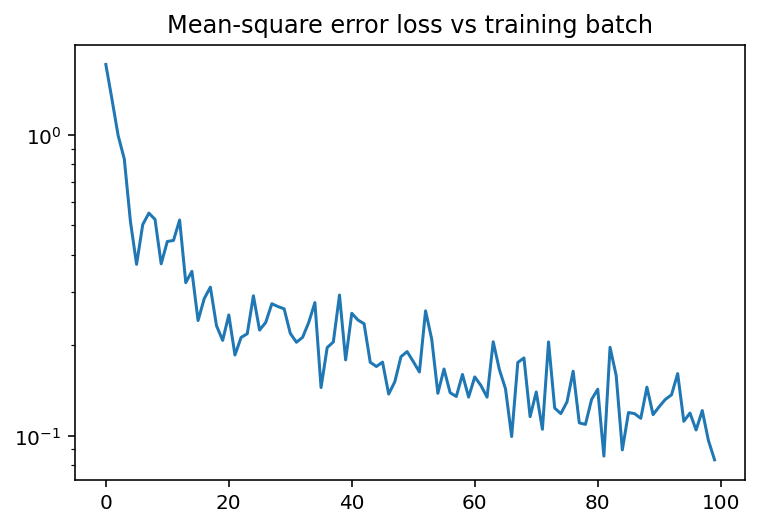

In [174]:
# run this cell multiple times to continue training!

for idx_batch in range(num_training_batches):
    # get training batch:
    subkey,key = jax.random.split( key )
    x, y_target = duffing_produce_training_batch( subkey, batchsize, 
                                                 value_ranges, num_frequency_bins)
        
    # get loss and its gradient with respect to network parameters:
    loss, grads = mse_loss_batch_val_grad( x, y_target, params )

    # update the network parameters:
    updates, opt_state = optimizer.update( grads, opt_state)
    params = optax.apply_updates( params, updates )

    # add the loss to the list:
    losses.append(loss)

plt.plot( losses )
plt.yscale( "log" )
plt.title("Mean-square error loss vs training batch")
plt.show()

Now test how well the neural network actually performs. Run it on a random training batch (now of larger batchsize). Then plot the network's predictions for the parameters vs the true parameter values, which are known in the training batch.

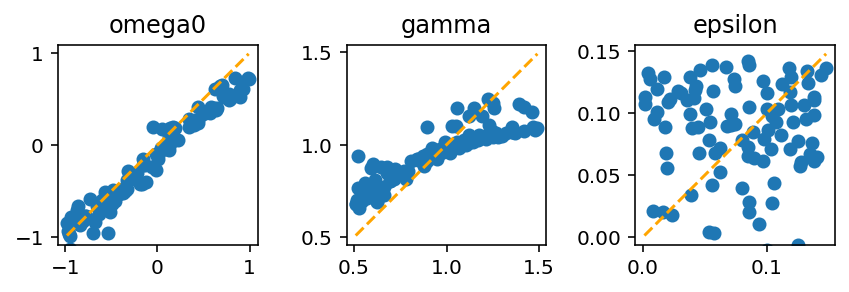

In [175]:
subkey,key = jax.random.split( key )
x, y_target = duffing_produce_training_batch( subkey, 100, 
                                             value_ranges, num_frequency_bins)
y = NN_MLP_with_tanh_batch(x,params)

fig,ax = plt.subplots(ncols=3)
for idx, label in enumerate(["omega0","gamma","epsilon"]):
    ax[idx].scatter(y_target[:,idx],y[:,idx])
    min_max_values=[jnp.min(y_target[:,idx]),jnp.max(y_target[:,idx])]
    ax[idx].plot(min_max_values,min_max_values,"--",color="orange")
    ax[idx].set_ylim(ax[idx].get_xlim())
    ax[idx].set_title(label)
    ax[idx].set_aspect(1.0)
fig.tight_layout()

Ideally, all the dots should lie on the orange line, indicating that the network prediction (vertical) is identical to the true value (horizontal). Apparently, it is most difficult for the network to make good predictions for the nonlinearity strength ```epsilon```.

```{admonition} Exercise
Run the training loop above several times (or set the num_training_batches to a higher value and then run it). After each run, observe that the network performs better!
```

```{admonition} Exercise
Add noise to the training samples, by writing a new training_batch function that calls the old one and adds noise. Use jax.random.normal. Make sure not to forget to split the random key, as shown already in the training loop! Observe how the network can learn in spite of the noise. Also, plot a few of the noisy response curves.
```

### Train a neural network to predict the parameters by looking at a 2D image of several response curves with a sweep of the force

This is still to be completed (work in progress). It will showcase the use of convolutional neural networks.

In [179]:
zs,ts,omegas = solve_duffing_force_batch( 0.0+0.01j, 0.0, 1.0, 
                      0.3, jnp.linspace(0.1,1.0,100), -4.0, 
                    +4.0,
                      200.0, 400 )


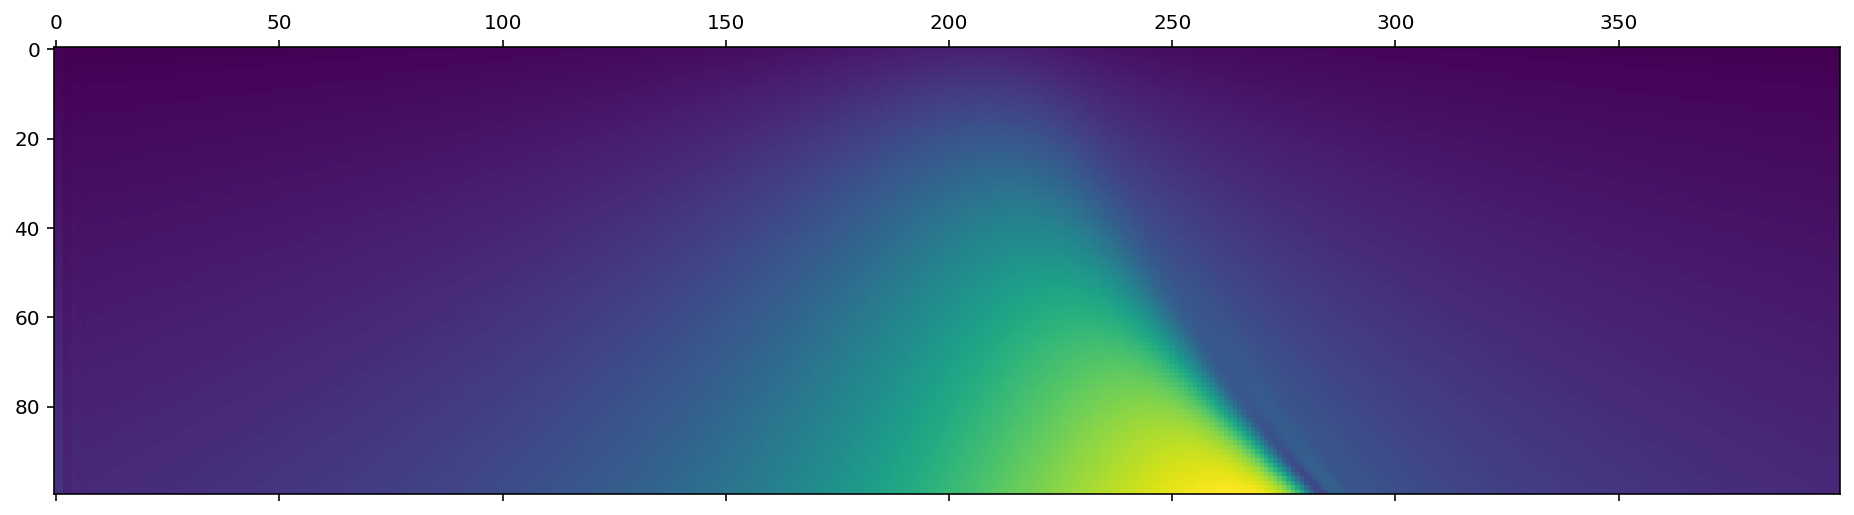

In [180]:
plt.matshow( jnp.abs(zs) )
plt.show()

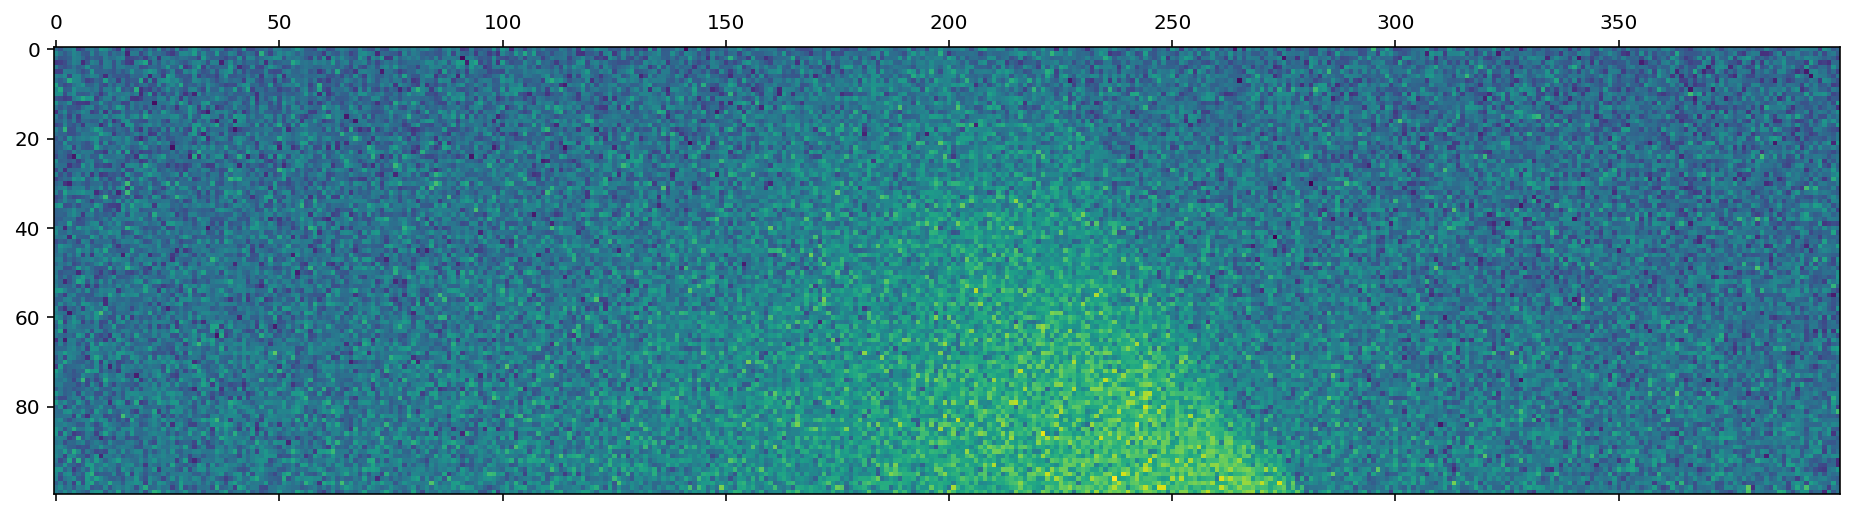

In [181]:
key = jax.random.key(42)
noise = jax.random.normal(key,zs.shape)

plt.matshow( jnp.abs(zs) + 0.5*noise)
plt.show()

In [182]:
zsnew = jax.image.resize(zs, (50,50), "cubic")

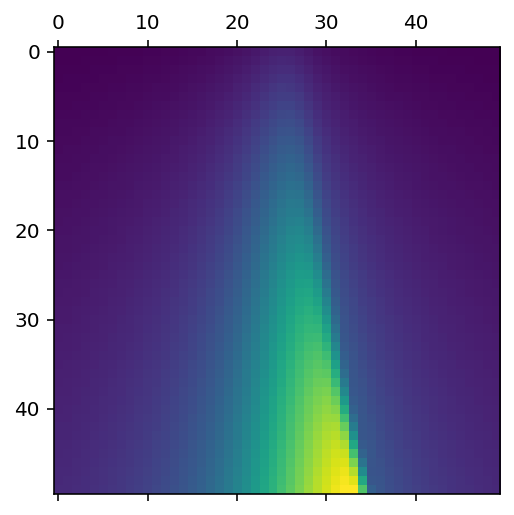

In [183]:
plt.matshow( jnp.abs(zsnew) )
plt.show()